In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:06<00:00, 192MB/s]
100% 1.04G/1.04G [00:06<00:00, 165MB/s]


In [3]:
!unzip \*zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
import pydot
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
import pydot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
BASE_DIR = "/content/" # For kaggle

In [6]:
model = ResNet50()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

102967424/102967424 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [8]:
# extract features from image
features = {}
directory = os.path.join('Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for alexnet
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
pickle.dump(features, open(os.path.join('resnet50_features.pkl'), 'wb'))

In [ ]:
with open(os.path.join('resnet50_features.pkl'), 'rb') as f:
 features = pickle.load(f)

In [10]:
with open(os.path.join('captions.txt'), 'r') as f:
 next(f)
 captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# preprocess the text
clean(mapping)

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

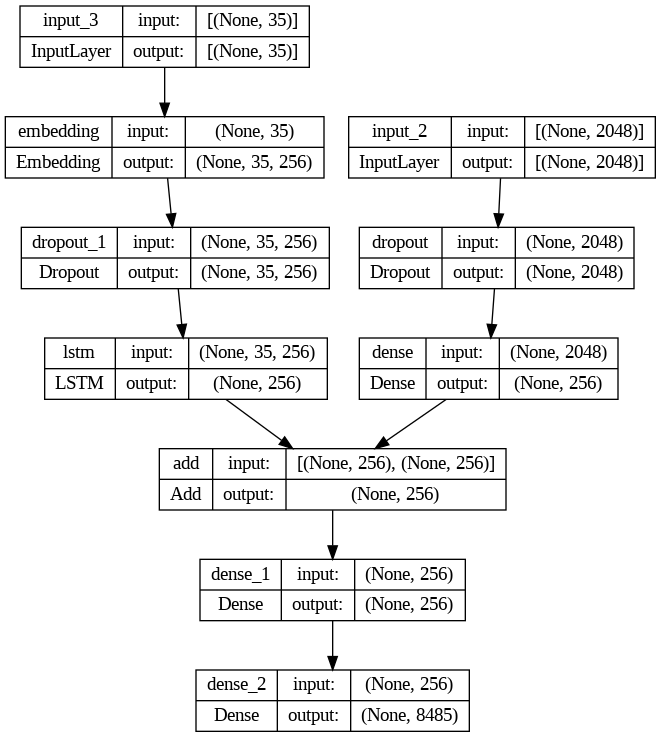

In [19]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

plot_model(model, show_shapes=True)

In [20]:
# Assuming you have defined the model and compiled it with an optimizer and loss function before training.

# Training parameters
epochs = 30
batch_size = 32
steps = len(train) // batch_size
history = {'loss': [], 'accuracy': []}

# Training loop
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)  # Missing parentheses here

    # fit for one epoch
    history_epoch = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    # Store the loss and accuracy of the current epoch
    history['loss'].extend(history_epoch.history['loss'])
    history['accuracy'].extend(history_epoch.history['accuracy'])

    # Calculate and display the average accuracy for the current epoch
    avg_accuracy = np.mean(history_epoch.history['accuracy'])
    print(f'Epoch {i + 1}/{epochs} - Loss: {history_epoch.history["loss"][-1]:.4f} - Accuracy: {avg_accuracy:.4f}')

227/227 [==============================] - 91s 370ms/step - loss: 5.2510 - accuracy: 0.1561
Epoch 1/30 - Loss: 5.2510 - Accuracy: 0.1561
227/227 [==============================] - 64s 280ms/step - loss: 4.0177 - accuracy: 0.2578
Epoch 2/30 - Loss: 4.0177 - Accuracy: 0.2578
227/227 [==============================] - 65s 284ms/step - loss: 3.6071 - accuracy: 0.2886
Epoch 3/30 - Loss: 3.6071 - Accuracy: 0.2886
227/227 [==============================] - 63s 279ms/step - loss: 3.3596 - accuracy: 0.3061
Epoch 4/30 - Loss: 3.3596 - Accuracy: 0.3061
227/227 [==============================] - 64s 280ms/step - loss: 3.1748 - accuracy: 0.3206
Epoch 5/30 - Loss: 3.1748 - Accuracy: 0.3206
227/227 [==============================] - 64s 281ms/step - loss: 3.0284 - accuracy: 0.3341
Epoch 6/30 - Loss: 3.0284 - Accuracy: 0.3341
227/227 [==============================] - 63s 277ms/step - loss: 2.9072 - accuracy: 0.3472
Epoch 7/30 - Loss: 2.9072 - Accuracy: 0.3472
227/227 [==============================] 

In [21]:
model.save("resnet50.h5")


In [ ]:
model.load_weights("/content/resnet50.h5")

In [22]:
history.keys()

dict_keys(['loss', 'accuracy'])

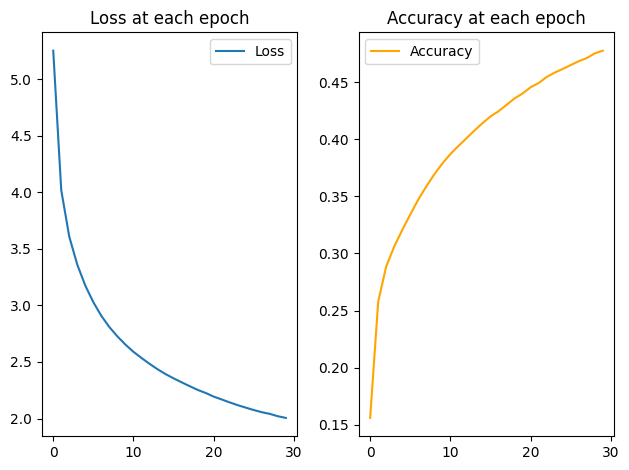

In [23]:
loss = history['loss']
accuracy = history['accuracy']
plt.subplot(1, 2, 1)
plt.plot(range(epochs),loss,label='Loss')
plt.legend(loc='best')
plt.title('Loss at each epoch')
plt.subplot(1, 2, 2)
plt.plot(range(epochs),accuracy,label='Accuracy', color = 'orange')
plt.legend(loc='best')
plt.title('Accuracy at each epoch')
plt.tight_layout()
plt.show()

In [24]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [25]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [26]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.557090
BLEU-2: 0.333546


In [27]:
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

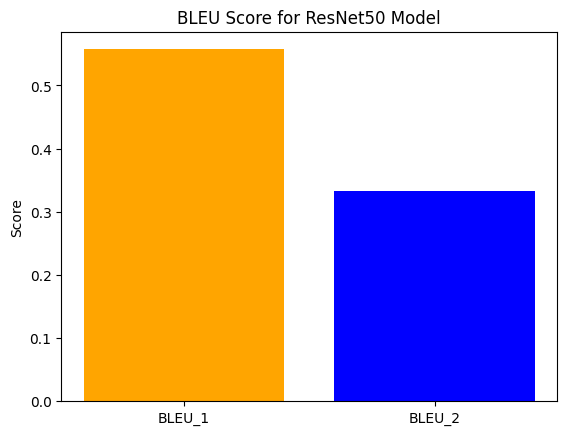

In [28]:
import matplotlib.pyplot as plt
x = ["BLEU_1", "BLEU_2"]
y = [b1, b2]
plt.bar(x, y, color = ['orange', 'blue'])
plt.title("BLEU Score for ResNet50 Model")
plt.ylabel("Score")
plt.show()

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq male hiker wearing green jacket is posing next to large glacier endseq
startseq man with camera and an ice structure behind him endseq
startseq man with camera crouching on ice endseq
startseq man with camera kneels in front of giant hill of snow endseq
startseq the mountain climber prepares to take photo endseq
--------------------Predicted--------------------
startseq man wearing summer clothes and hat is ascending snow attached to scale ice endseq


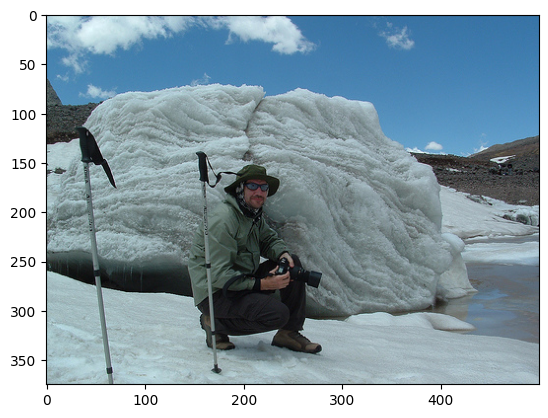

In [30]:
generate_caption("2097420505_439f63c863.jpg")

---------------------Actual---------------------
startseq brown dog runs for white and black dog on the grass endseq
startseq white dog and brown dog play in the grass endseq
startseq the dogs are in the field playing endseq
startseq two dogs playing on grass endseq
startseq two dogs play together endseq
--------------------Predicted--------------------
startseq two dogs run through field endseq


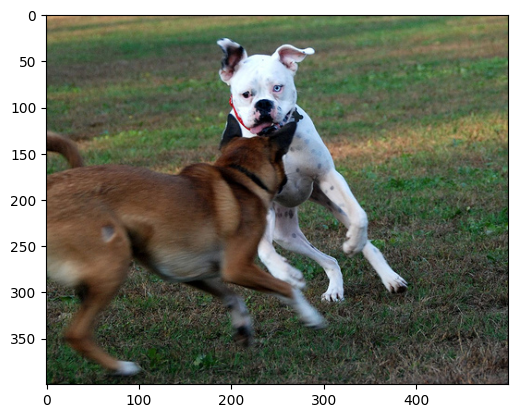

In [31]:
generate_caption("1778020185_1d44c04dae.jpg")

---------------------Actual---------------------
startseq girl in ballet fairy costume is touched by wand endseq
startseq young girl performing the nutcracker endseq
startseq the little girl is standing on stage dressed up as pink fairy endseq
startseq "the tiny girl dressed in butterfly ballet costume waves her wand near nutcracker statue ." endseq
startseq young girl waving turquiose leotard and pink tutu with wings waving wand endseq
--------------------Predicted--------------------
startseq little girl in pink tutu is touched in the air endseq


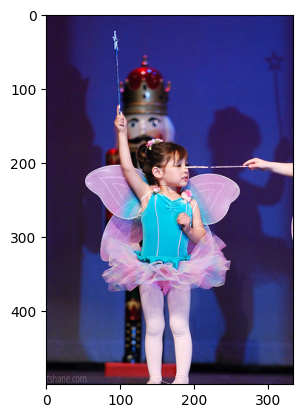

In [32]:
generate_caption("2097489021_ca1b9f5c3b.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq woman in dress sits on bench endseq


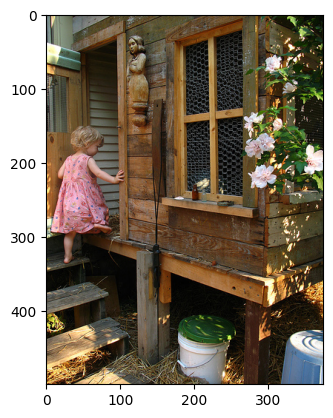

In [33]:
generate_caption("1000268201_693b08cb0e.jpg")